# Color Image Edge Detection
> 0712238 Yan-Tong Lin, for DIP2021spring HW6

## DIP Homework Chapter 6
1. Please use a gradient computed in RGB color vector space to detect the edge for the image, ‘lenna-RGB.tif’ as Fig. 6.44(b) in pp.453. Please describe your method, procedures, final gradient image and print out the source code. (3X10=40)
2. Repeat (1) steps in the image ‘Visual resolution.gif’. (3X10=40)
3. Please comment and compare your two designs. (20)

In [1]:
%matplotlib inline

In [2]:
from IPython.display import display, Math, Latex
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from scipy import signal
from scipy import misc
import cv2 as cv

In [3]:
cv.__version__

'4.5.1'

## Solution

### Edge detection with the gradient in RGB color vector space

#### RGB vector space
* $\text{image} = (R,G,B)$
    * we treat the image pixel as a color vector $c(x,y)$
* $u = \frac{\partial R}{\partial x}+ \frac{\partial G}{\partial x}+ \frac{\partial B}{\partial x}$
* $v = \frac{\partial R}{\partial y}+ \frac{\partial G}{\partial y}+ \frac{\partial B}{\partial y}$
* $g_{xx} = u^tu$
* $g_{yy} = v^tv$
* $g_{xy} = u^tv$
* $\theta = \frac{1}{2} \text{arctan}(\frac{2g_{xy}}{g_{xx}-g_{yy}})$
    * It's shown (in the reference) that the direction of maximum rate of change of $c(x,y) \in R^3$ (the color vector) is given by the angle $\theta$
* $F_\theta = {\{\frac 1 2 [(g_{xx}+g_{yy})+(g_{xx}-g_{yy})\cos 2\theta + 2g_{xy}\sin 2\theta] \}}^{\frac 1 2}$
    * And the change of $c$ resp. to $\theta$ is given by $F_\theta$ 

#### Solution to Numerical Issue
* We handle division by zeros with the replacememt of zeros with small real numbers
* We handle square roots of negative values by taking absolute values.

#### Recap: Sobel filter
Partial derivative can be estimated by the Sobel filters.
$$
\text{filter for }f_x = \left(
\begin{matrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 \\
\end{matrix}
\right) \\
$$
$$
\text{filter for }f_y = \left(
\begin{matrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1 \\
\end{matrix}
\right) \\
$$
        
### Comparison
For the second picture, we transform it into a `tif` file before processing. (`gif`s are frames of pictures, not pictures).
The parameters (kernel size for Sobel, Gaussian blur, transform the result with log transform or not...) are adjusted so that visual effect is better. 

In figure 1, there are details that I want to preserve in the result (the texure of hat/hair, etc.) so the kernel sizes are chosen to be a bit smaller. In figure 2, the kernel sizes are chosen to be larger to avoid the artifacts caused by noises. The results may not be ideal but I tried.


### References
* Di Zenzo, Silvano. "A note on the gradient of a multi-image." Computer vision, graphics, and image processing 33.1 (1986): 116-125.

## Some Ancillary Functions

In [4]:
# Utilities
def normed(img):
    return cv.normalize(img, img, 0, 1., cv.NORM_MINMAX)


def demo(imgname, ksize=3, blur_ksize=5, transform=True, c = 1, base=1, thre=0):
    ddepth = cv.CV_64F
    imgs = []
    img = cv.imread(imgname)
    # open cv BGR to RGB
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs += [img]
    # blurring to denoise before edge detection
    img = cv.GaussianBlur(img,(blur_ksize ,blur_ksize),0)
    imgs += [img]
    # split the channels
    (R, G, B) = cv.split(img)
    # calculate paritial derivative with Sobel filter
    gs = [[], []] ## gs[0][1] = \partial G(1) \partial x(0)
    for channel in (B,G,R):
        g_x = cv.Sobel(channel, ddepth, 1, 0, ksize=ksize)
        g_y = cv.Sobel(channel, ddepth, 0, 1, ksize=ksize)
        # normalized to int8
        # g_x = cv.convertScaleAbs(g_x)
        # g_y = cv.convertScaleAbs(g_y)
        gs[0] += [g_x]
        gs[1] += [g_y]
    # calculate the edge
    gxx = (gs[0][0]**2+gs[0][1]**2+gs[0][2]**2)
    gyy = (gs[1][0]**2+gs[1][1]**2+gs[1][2]**2)
    gxy = (gs[0][0]*gs[1][0]+gs[0][1]*gs[1][1]+gs[0][2]*gs[1][2])
    d = (gxx-gyy).astype('float64')
    d[d==0] = 1e-10
    # theta that maximize change in RGB space
    theta = (1/2)*np.arctan(2.0*gxy/d)
    # the maximum change in RGB space 
    f = ((1/2)*np.abs((gxx+gyy+(gxx-gyy)*np.cos(2*theta)+2*gxy*np.sin(2*theta)))**(0.5))
    # transform to improve visual effect
    if transform == True:
         f = c*np.log(f+base)
         f[f<thre] = 0
    f = normed(f)
    imgs += [f]
    
    # display
    print(f.shape)
    n_plots = 3
    titles = ['original', 'blurred', 'edge detected in RGB vector space']
    images = imgs
    fig, axs = plt.subplots(1, n_plots, figsize=[15, 15])
    for i in range(len(titles)):
        if i == 2:
            axs[i].imshow(images[i], 'gray')
        else:
            axs[i].imshow(images[i])
        axs[i].set_title(titles[i])
        axs[i].set_xticks([]), axs[i].set_yticks([])
    plt.show()
    return 

## Problem 1 --- 'lenna-RGB.tif'

(512, 512)


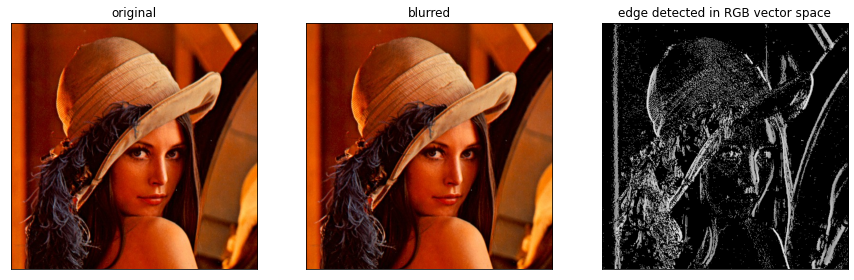

In [5]:
imgname = 'lenna-RGB.tif'
#demo(imgname, ksize=3, blur_ksize=3, thre=4.5)
demo(imgname, ksize=1, blur_ksize=1, transform = True, c = 1, base=0.1, thre=2.7)

## Problem 2 --- 'Visual resolution.tif'

(438, 612)


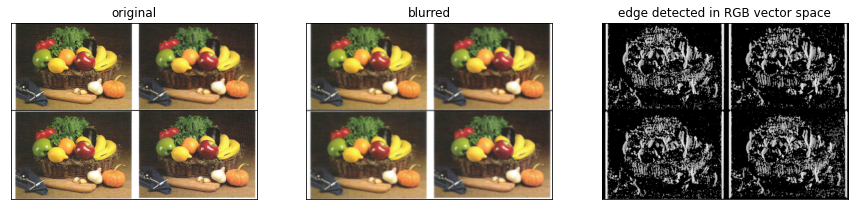

In [6]:
imgname = 'Visual_resolution.tif' # transform to tif file to read
demo(imgname, ksize=3, blur_ksize=5, transform = True, c = 1, base=0.1, thre=3.2)